## Testing AUCell cell-level pathway activity scoring

In [32]:
from pathlib import Path
import os
import decoupler
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import scanpy as sc

In [2]:
# set GOI

GOI = 'CASP8'

In [3]:
# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir( wdir )

adata = sc.read_h5ad('data/output/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [4]:
# get reactome pathway data

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [5]:
reactome = gmt_to_decoupler("data/c2.cp.reactome.v2023.2.Hs.symbols.gmt")
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 300)]

In [6]:
# run AUCell

decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

In [34]:
# correlation between each pathways AUCell score and CASP8 expression
pathways_goi = reactome[(reactome["geneset"].isin(gsea_genesets)) & (reactome["genesymbol"].isin(adata.var_names)) & 
         (reactome['genesymbol'] == GOI)]

# get the AUCell scores for the genes in the pathway
goi_expression = adata.to_df()[GOI].values
def calc_correlation(column):
    return np.corrcoef(column, goi_expression)[0, 1]
pathways_goi.loc[:, 'correlation'] = adata.obsm['aucell_estimate'][pathways_goi['geneset']].apply(calc_correlation).values
pathways_goi = pathways_goi.sort_values('correlation', key=pd.Series.abs, ascending=False)
pathways_goi

,geneset,genesymbol,correlation
65480,REACTOME_REGULATION_OF_NF_KAPPA_B_SIGNALING,CASP8,0.203549
87046,REACTOME_TNFR1_INDUCED_PROAPOPTOTIC_SIGNALING,CASP8,0.201802
53343,REACTOME_NOD1_2_SIGNALING_PATHWAY,CASP8,0.198403
87226,REACTOME_TNF_SIGNALING,CASP8,0.167243
16796,REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INT...,CASP8,0.148978
54575,REACTOME_NUCLEOTIDE_BINDING_DOMAIN_LEUCINE_RIC...,CASP8,0.143081
7356,REACTOME_CASPASE_ACTIVATION_VIA_DEATH_RECEPTOR...,CASP8,0.142647
69512,REACTOME_RIPK1_MEDIATED_REGULATED_NECROSIS,CASP8,0.132642
7384,REACTOME_CASPASE_ACTIVATION_VIA_EXTRINSIC_APOP...,CASP8,0.125425
64286,REACTOME_REGULATED_NECROSIS,CASP8,0.119674


In [58]:
top_pathways = list(pathways_goi['geneset'].values[:4])

adata.obs[top_pathways] = adata.obsm["aucell_estimate"][top_pathways]

/Users/samibening/micromamba/envs/gsea/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/samibening/micromamba/envs/gsea/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


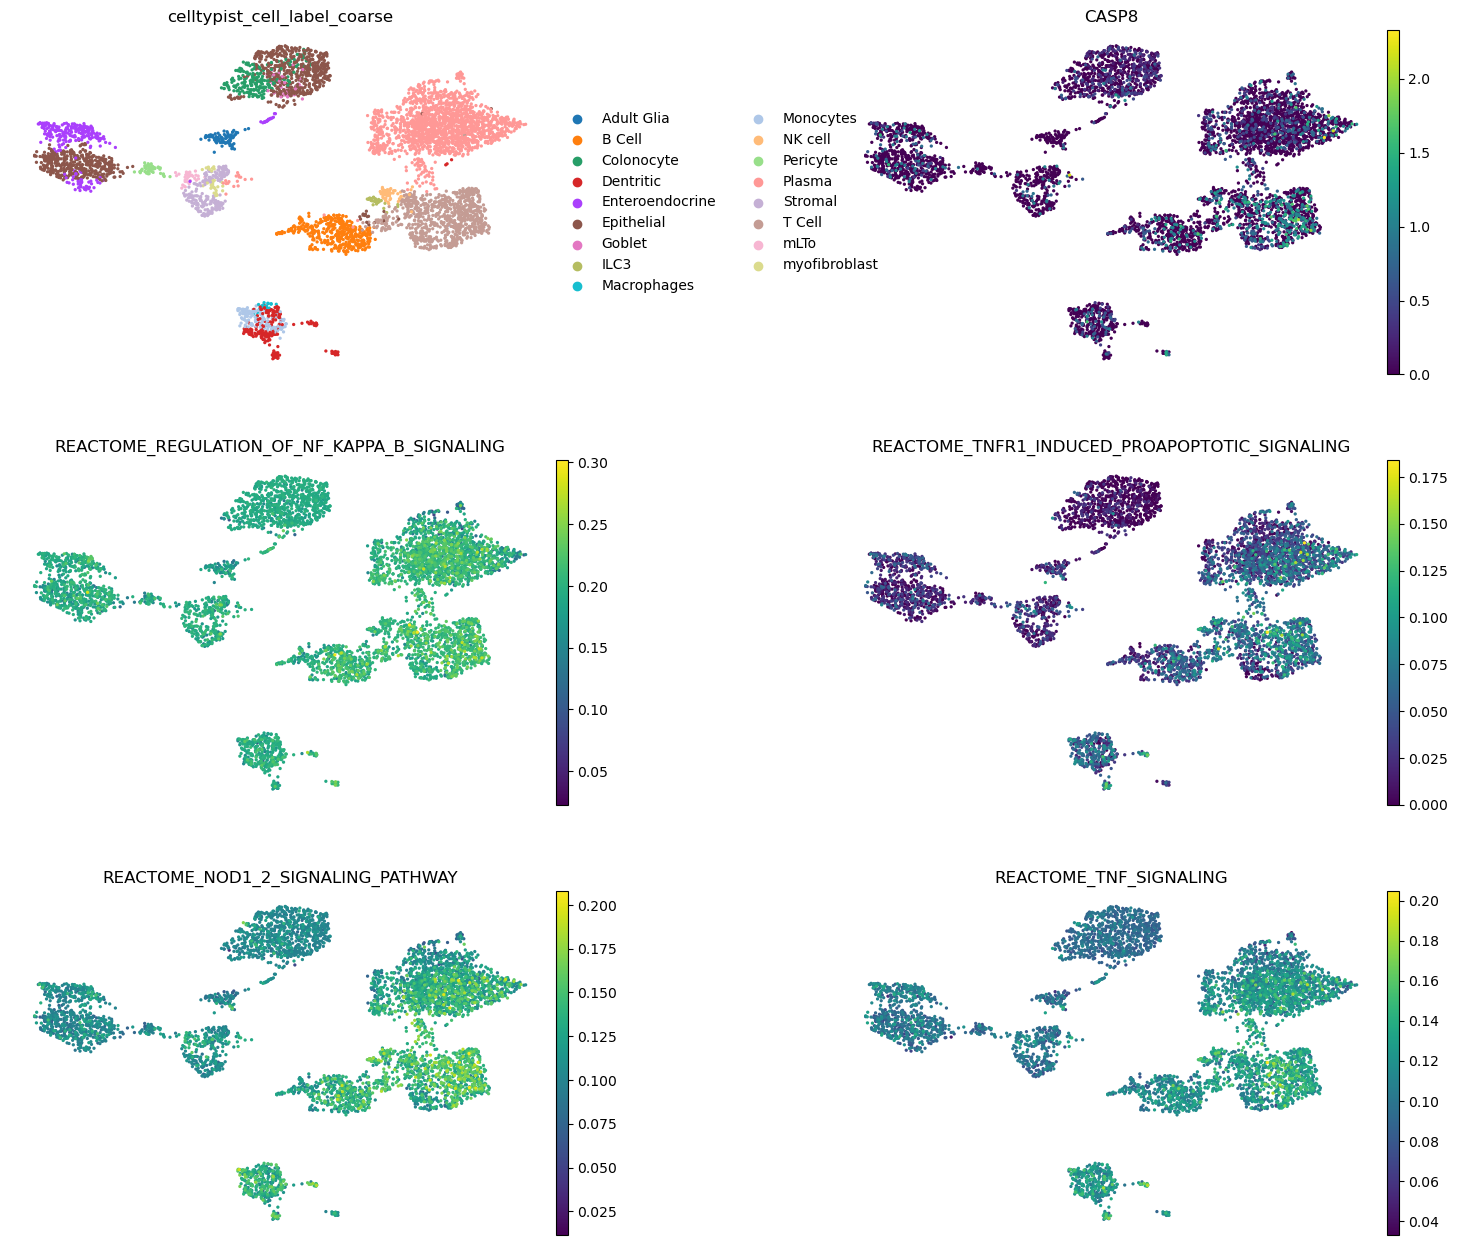

In [59]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", GOI] + top_pathways,
    frameon=False,
    ncols=2,
    wspace=0.4,
)